# 1. Business Understanding

- Mengembangkan Model SImulasi Otomatisasi HIdroponik mas dengan model Prophet dan Arima
- Membandingkan 2 Metode Algoritma Prophet dan ARIMA mana yang terbaik dan efektif.
- Mengembangkan Aplikasi Simulasi Hidroponik (HydroSim) untuk mlakukan simulasi otomasisasi hidroponik tanaman selada dengan menggunakan model terbaik

# 2. Data Understanding

## Import All Library or Package

In [ ]:
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from tabulate import tabulate
from sklearn.metrics import confusion_matrix
import joblib

## Load Dataset

In [ ]:
df_train = pd.read_csv("/content/DataFieldFULLSIOHITrainFULLPattern01072024.csv")
df_test = pd.read_csv("/content/DataFieldFULLSIOHITest01072024.csv")

## EDA

In [ ]:
# Display Head Data from Dataset Train
df_train.head()

,day,hole,time,temperature,humidity,light,pH,EC,TDS,WaterTemp,Label,LeafCount
0,1,1,9.19,26.8,72,17820,7.2,677,340,26.1,Selada,3
1,1,2,9.23,26.6,72,16490,7.2,677,338,26.1,Selada,3
2,1,3,9.27,26.4,72,15160,7.2,678,334,26.1,Selada,3
3,1,4,9.31,26.2,72,13830,7.2,677,338,26.1,Selada,3
4,1,5,9.35,26.2,72,12500,7.2,673,340,26.1,Selada,3


In [ ]:
# Display Head Data from Dataset Test
df_test.head()

,day,hole,time,temperature,humidity,light,pH,EC,TDS,WaterTemp,Label,LeafCount
0,1,1,9.19,26.8,72,17820,7.1,918,459,26.1,Selada,3
1,1,2,9.23,26.6,72,16490,7.1,918,459,26.1,Selada,3
2,1,3,9.27,26.4,72,15160,7.1,915,454,26.1,Selada,3
3,1,4,9.31,26.2,72,13830,7.1,915,457,26.1,Selada,3
4,1,5,9.35,26.2,72,12500,7.1,918,461,26.1,Selada,4


In [ ]:
# Display Banyak Data masing masing Dataframe
print("Banyak data dari data train", len(df_train))
print("Banyak data dari data test", len(df_test))

Banyak data dari data train 8000
Banyak data dari data test 6400


In [ ]:
# Display tipe data dari Data Train
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day          8000 non-null   int64  
 1   hole         8000 non-null   int64  
 2   time         8000 non-null   float64
 3   temperature  8000 non-null   float64
 4   humidity     8000 non-null   int64  
 5   light        8000 non-null   int64  
 6   pH           8000 non-null   float64
 7   EC           8000 non-null   int64  
 8   TDS          8000 non-null   int64  
 9   WaterTemp    8000 non-null   float64
 10  Label        8000 non-null   object 
 11  LeafCount    8000 non-null   int64  
dtypes: float64(4), int64(7), object(1)
memory usage: 750.1+ KB


In [ ]:
# Check missing data

missing_data = pd.DataFrame({'total_missing': df_train.isnull().sum(),
                             'perc_missing': (df_train.isnull().sum()/2634)*100})

missing_data

,total_missing,perc_missing
day,0,0.0
hole,0,0.0
time,0,0.0
temperature,0,0.0
humidity,0,0.0
light,0,0.0
pH,0,0.0
EC,0,0.0
TDS,0,0.0
WaterTemp,0,0.0


In [ ]:
# Check missing data

missing_data = pd.DataFrame({'total_missing': df_test.isnull().sum(),
                             'perc_missing': (df_test.isnull().sum()/2634)*100})

missing_data

,total_missing,perc_missing
day,0,0.0
hole,0,0.0
time,0,0.0
temperature,0,0.0
humidity,0,0.0
light,0,0.0
pH,0,0.0
EC,0,0.0
TDS,0,0.0
WaterTemp,0,0.0


In [ ]:
df_train.describe()

,day,hole,time,temperature,humidity,light,pH,EC,TDS,WaterTemp,LeafCount
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,20.500000,5.000000,12.878269,27.147687,69.978750,30548.134375,7.185200,1332.533625,665.670500,27.194700,8.366000
std,11.544118,2.828604,2.761630,1.958960,16.376334,17976.792892,0.304376,493.701284,246.395326,2.946802,4.016536
min,1.000000,1.000000,7.370000,23.100000,40.000000,9003.000000,6.400000,514.000000,258.000000,22.300000,3.000000
25%,10.750000,3.000000,10.945000,25.700000,57.000000,17180.000000,6.900000,686.000000,348.000000,24.900000,5.000000
50%,20.500000,5.000000,13.225000,26.800000,69.000000,28830.000000,7.200000,1538.000000,760.000000,26.500000,8.000000
75%,30.250000,7.000000,15.405000,28.100000,84.000000,41422.500000,7.300000,1599.000000,799.000000,28.900000,11.000000
max,40.000000,10.000000,17.020000,32.600000,99.000000,168770.000000,8.200000,2467.000000,1758.000000,34.100000,20.000000


In [ ]:
# Drop uninmportant column
df_train = df_train.drop(columns=['Label'])
df_test = df_test.drop(columns=['Label'])

In [ ]:
# Display Correlation Matrix
cor_matrix = df_train.corr()
cor_matrix

,day,hole,time,temperature,humidity,light,pH,EC,TDS,WaterTemp,LeafCount
day,1.000000e+00,1.249092e-16,0.003883,-0.171041,0.144791,-0.107481,0.281429,0.829152,0.830171,-0.537363,0.890994
hole,1.249092e-16,1.000000e+00,0.029839,0.013435,0.000918,-0.025341,-0.028576,-0.125153,-0.124434,-0.012963,0.064658
time,3.883354e-03,2.983932e-02,1.000000,0.235844,-0.513122,0.364059,0.225903,0.008172,0.007146,0.457679,0.008695
temperature,-1.710405e-01,1.343533e-02,0.235844,1.000000,-0.362850,0.210620,0.023773,-0.144243,-0.144734,0.408470,-0.168226
humidity,1.447911e-01,9.176021e-04,-0.513122,-0.362850,1.000000,-0.354230,-0.046467,0.122619,0.121974,-0.421257,0.113101
light,-1.074807e-01,-2.534086e-02,0.364059,0.210620,-0.354230,1.000000,0.003685,-0.121969,-0.120875,0.365463,-0.071180
pH,2.814291e-01,-2.857631e-02,0.225903,0.023773,-0.046467,0.003685,1.000000,0.295695,0.294266,-0.073158,0.152390
EC,8.291518e-01,-1.251526e-01,0.008172,-0.144243,0.122619,-0.121969,0.295695,1.000000,0.997981,-0.434209,0.718760
TDS,8.301709e-01,-1.244343e-01,0.007146,-0.144734,0.121974,-0.120875,0.294266,0.997981,1.000000,-0.435360,0.720149
WaterTemp,-5.373625e-01,-1.296301e-02,0.457679,0.408470,-0.421257,0.365463,-0.073158,-0.434209,-0.435360,1.000000,-0.489908


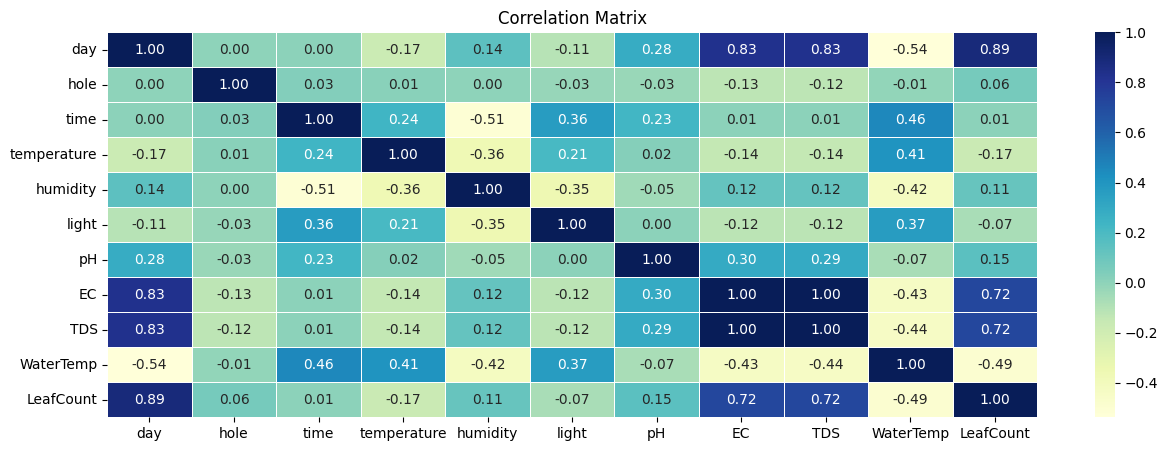

In [ ]:
# Heatmap of the correlation matrix
plt.figure(figsize=(15, 5))
sns.heatmap(cor_matrix, annot=True, cmap='YlGnBu', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

## Visualization

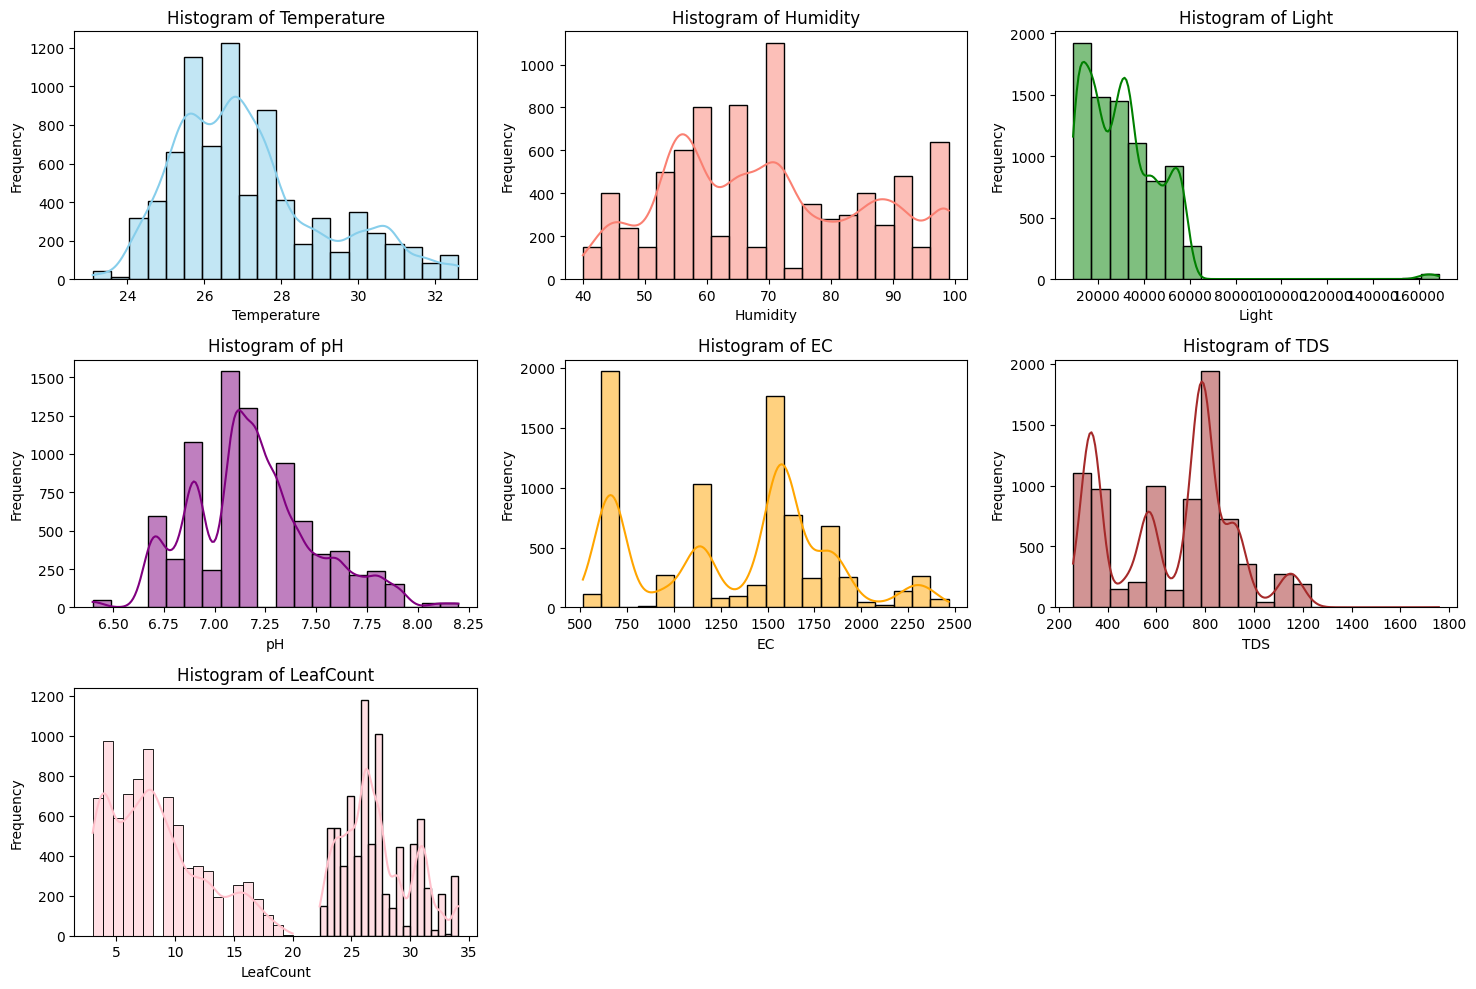

In [ ]:
# Plotting histograms
plt.figure(figsize=(15, 10))

# Histogram for 'temperature'
plt.subplot(3, 3, 1)
sns.histplot(df_train['temperature'], bins=20, kde=True, color='skyblue')
plt.title('Histogram of Temperature')
plt.xlabel('Temperature')
plt.ylabel('Frequency')

# Histogram for 'humidity'
plt.subplot(3, 3, 2)
sns.histplot(df_train['humidity'], bins=20, kde=True, color='salmon')
plt.title('Histogram of Humidity')
plt.xlabel('Humidity')
plt.ylabel('Frequency')

# Histogram for 'light'
plt.subplot(3, 3, 3)
sns.histplot(df_train['light'], bins=20, kde=True, color='green')
plt.title('Histogram of Light')
plt.xlabel('Light')
plt.ylabel('Frequency')

# Histogram for 'pH'
plt.subplot(3, 3, 4)
sns.histplot(df_train['pH'], bins=20, kde=True, color='purple')
plt.title('Histogram of pH')
plt.xlabel('pH')
plt.ylabel('Frequency')

# Histogram for 'EC'
plt.subplot(3, 3, 5)
sns.histplot(df_train['EC'], bins=20, kde=True, color='orange')
plt.title('Histogram of EC')
plt.xlabel('EC')
plt.ylabel('Frequency')

# Histogram for 'TDS'
plt.subplot(3, 3, 6)
sns.histplot(df_train['TDS'], bins=20, kde=True, color='brown')
plt.title('Histogram of TDS')
plt.xlabel('TDS')
plt.ylabel('Frequency')

# Histogram for 'WaterTemp'
plt.subplot(3, 3, 7)
sns.histplot(df_train['WaterTemp'], bins=20, kde=True, color='pink')
plt.title('Histogram of WaterTemp')
plt.xlabel('WaterTemp')
plt.ylabel('Frequency')

# Histogram for 'LeafCount'
plt.subplot(3, 3, 7)
sns.histplot(df_train['LeafCount'], bins=20, kde=True, color='pink')
plt.title('Histogram of LeafCount')
plt.xlabel('LeafCount')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Visualisasi Terhadap Hari

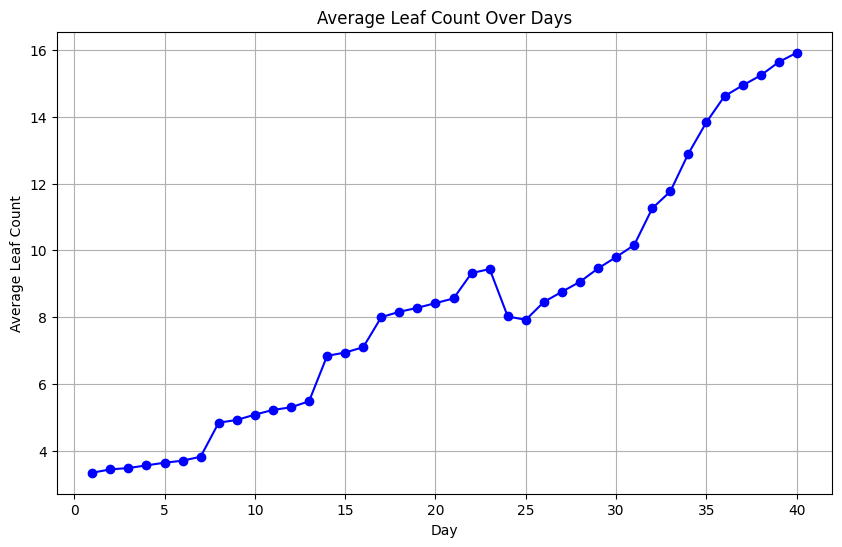

In [ ]:
# Group by 'day' and calculate the mean of 'LeafCount'
average_leaf_count = df_train.groupby('day')['LeafCount'].mean().reset_index()

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(average_leaf_count['day'], average_leaf_count['LeafCount'], marker='o', linestyle='-', color='b')

# Adding titles and labels
plt.title('Average Leaf Count Over Days')
plt.xlabel('Day')
plt.ylabel('Average Leaf Count')

# Display the plot
plt.grid(True)
plt.show()

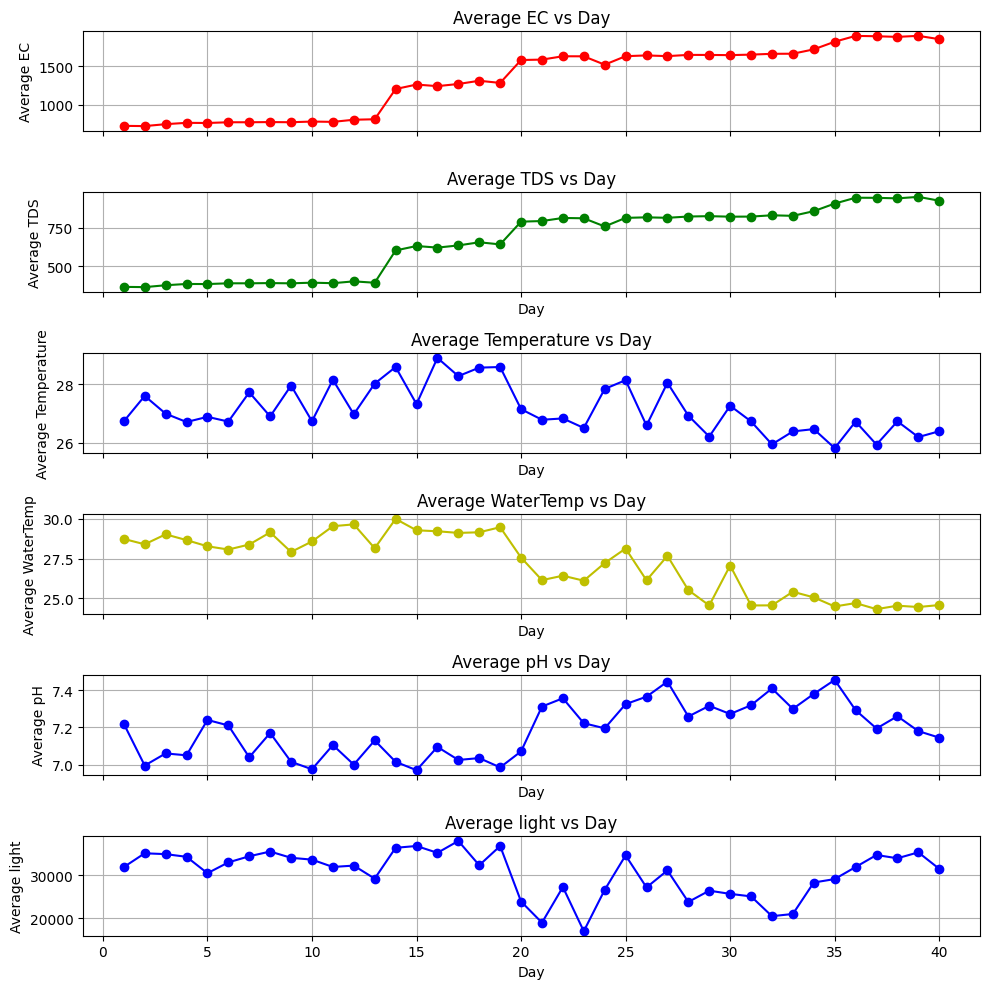

In [ ]:
# Group by 'day' and calculate the mean of 'EC' and 'TDS'
average_values = df_train.groupby('day')[['EC', 'TDS', 'temperature', 'WaterTemp', 'pH', 'light']].mean().reset_index()

# Creating the subplots
fig, axs = plt.subplots(6, 1, figsize=(10, 10), sharex=True)

# Plotting average EC vs day
axs[0].plot(average_values['day'], average_values['EC'], marker='o', linestyle='-', color='r')
axs[0].set_title('Average EC vs Day')
axs[0].set_ylabel('Average EC')
axs[0].grid(True)

# Plotting average TDS vs day
axs[1].plot(average_values['day'], average_values['TDS'], marker='o', linestyle='-', color='g')
axs[1].set_title('Average TDS vs Day')
axs[1].set_xlabel('Day')
axs[1].set_ylabel('Average TDS')
axs[1].grid(True)

# Plotting average temperature vs day
axs[2].plot(average_values['day'], average_values['temperature'], marker='o', linestyle='-', color='b')
axs[2].set_title('Average Temperature vs Day')
axs[2].set_xlabel('Day')
axs[2].set_ylabel('Average Temperature')
axs[2].grid(True)

# Plotting average WaterTemp vs day
axs[3].plot(average_values['day'], average_values['WaterTemp'], marker='o', linestyle='-', color='y')
axs[3].set_title('Average WaterTemp vs Day')
axs[3].set_xlabel('Day')
axs[3].set_ylabel('Average WaterTemp')
axs[3].grid(True)

# Plotting average pH vs day
axs[4].plot(average_values['day'], average_values['pH'], marker='o', linestyle='-', color='b')
axs[4].set_title('Average pH vs Day')
axs[4].set_xlabel('Day')
axs[4].set_ylabel('Average pH')
axs[4].grid(True)

# Plotting average light vs day
axs[5].plot(average_values['day'], average_values['light'], marker='o', linestyle='-', color='b')
axs[5].set_title('Average light vs Day')
axs[5].set_xlabel('Day')
axs[5].set_ylabel('Average light')
axs[5].grid(True)

# Displaying the plots
plt.tight_layout()
plt.show()

# 3. Data Preparation

In [ ]:
# Make a Backup dataframe
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

## Make a column datetime

This column is very important to make model for Forecasting

### Make column Time to the actually time column

In [ ]:
df_train_copy['time']
df_test_copy['time']

0        9.19
1        9.23
2        9.27
3        9.31
4        9.35
        ...  
6395    16.38
6396    16.42
6397    16.43
6398    16.44
6399    16.45
Name: time, Length: 6400, dtype: float64

In [ ]:
# Tambahkan "0" di depan nilai yang hanya satu digit di bagian jam
df_train_copy['time'] = df_train_copy['time'].apply(lambda x: '{:.2f}'.format(x))
df_test_copy['time'] = df_test_copy['time'].apply(lambda x: '{:.2f}'.format(x))

# Konversi 'time' ke format waktu yang benar
df_train_copy['time'] = pd.to_datetime(df_train_copy['time'], format='%H.%M').dt.time
df_test_copy['time'] = pd.to_datetime(df_test_copy['time'], format='%H.%M').dt.time

In [ ]:
df_train_copy.head(5)

,day,hole,time,temperature,humidity,light,pH,EC,TDS,WaterTemp,LeafCount
0,1,1,09:19:00,26.8,72,17820,7.2,677,340,26.1,3
1,1,2,09:23:00,26.6,72,16490,7.2,677,338,26.1,3
2,1,3,09:27:00,26.4,72,15160,7.2,678,334,26.1,3
3,1,4,09:31:00,26.2,72,13830,7.2,677,338,26.1,3
4,1,5,09:35:00,26.2,72,12500,7.2,673,340,26.1,3


### Make a column Datetime

In [ ]:
df_train_prep = df_train_copy.copy()
df_test_prep = df_test_copy.copy()

In [ ]:
df_train_prep = df_train_prep[['day', 'time', 'LeafCount']]
df_test_prep = df_test_prep[['day', 'time', 'LeafCount']]

In [ ]:
# Tentukan tanggal awal
start_date = pd.to_datetime('2024-07-01')

In [ ]:
# Ubah kolom 'time' menjadi string
df_train_prep['time'] = df_train_prep['time'].astype(str)
df_test_prep['time'] = df_test_prep['time'].astype(str)

# Buat kolom 'datetime' dengan menambahkan 'day' ke tanggal awal dan menggabungkan dengan 'time'
df_train_prep['datetime'] = df_train_prep.apply(lambda row: start_date + pd.Timedelta(days=row['day'] - 1) + pd.to_timedelta(row['time']), axis=1)
df_test_prep['datetime'] = df_test_prep.apply(lambda row: start_date + pd.Timedelta(days=row['day'] - 1) + pd.to_timedelta(row['time']), axis=1)


In [ ]:
print(df_train_prep.head())

   day      time  LeafCount            datetime
0    1  09:19:00          3 2024-07-01 09:19:00
1    1  09:23:00          3 2024-07-01 09:23:00
2    1  09:27:00          3 2024-07-01 09:27:00
3    1  09:31:00          3 2024-07-01 09:31:00
4    1  09:35:00          3 2024-07-01 09:35:00


## Data Pre-Processing

In [ ]:
df_test_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   day        6400 non-null   int64         
 1   time       6400 non-null   object        
 2   LeafCount  6400 non-null   int64         
 3   datetime   6400 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 200.1+ KB


In [ ]:
# Convert to correct data types
df_train_prep['day'] = df_train_prep['day'].astype(int)
df_train_prep['time'] = df_train_prep['time'].astype(str)
df_train_prep['LeafCount'] = df_train_prep['LeafCount'].astype(int)

# Convert to correct data types
df_test_prep['day'] = df_test_prep['day'].astype(int)
df_test_prep['time'] = df_test_prep['time'].astype(str)
df_test_prep['LeafCount'] = df_test_prep['LeafCount'].astype(int)

In [ ]:
# Convert to correct data types
df_train_copy['day'] = df_train_copy['day'].astype(int)
df_train_copy['time'] = df_train_copy['time'].astype(str)
df_train_copy['LeafCount'] = df_train_copy['LeafCount'].astype(int)

df_test_copy['day'] = df_test_copy['day'].astype(int)
df_test_copy['time'] = df_test_copy['time'].astype(str)
df_test_copy['LeafCount'] = df_test_copy['LeafCount'].astype(int)

In [ ]:
# Merge the 'datetime' column from df_prep into df_copy
df_train_model = pd.merge(df_train_copy, df_train_prep[['day', 'time', 'LeafCount', 'datetime']], on=['day', 'time', 'LeafCount'], how='inner')
df_test_model = pd.merge(df_test_copy, df_test_prep[['day', 'time', 'LeafCount', 'datetime']], on=['day', 'time', 'LeafCount'], how='inner')

# Debug: Check the result of the merge
print("df_model after merge:")
print(df_train_model.head())

df_model after merge:
   day  hole      time  temperature  humidity  light   pH   EC  TDS  \
0    1     1  09:19:00         26.8        72  17820  7.2  677  340   
1    1     1  09:19:00         26.8        72  17820  7.2  677  340   
2    1     1  09:19:00         26.8        72  17820  7.2  677  340   
3    1     1  09:19:00         26.8        72  17820  7.2  677  340   
4    1     2  09:23:00         26.6        72  16490  7.2  677  338   

   WaterTemp  LeafCount            datetime  
0       26.1          3 2024-07-01 09:19:00  
1       26.1          3 2024-07-01 09:19:00  
2       26.1          3 2024-07-01 09:19:00  
3       26.1          3 2024-07-01 09:19:00  
4       26.1          3 2024-07-01 09:23:00  


In [ ]:
# Drop duplicates
df_train_model = df_train_model.drop_duplicates(subset=['day', 'time', 'LeafCount'])
df_test_model = df_test_model.drop_duplicates(subset=['day', 'time', 'LeafCount'])

In [ ]:
# Set the 'datetime' column as the index and sort it
df_train_model.set_index('datetime', inplace=True)
df_train_model = df_train_model.sort_index()

# Set the 'datetime' column as the index and sort it
df_test_model.set_index('datetime', inplace=True)
df_test_model = df_test_model.sort_index()

In [ ]:
# Ensure that the data is sorted by datetime
df_train_model = df_train_model.sort_index()
df_test_model = df_test_model.sort_index()

In [ ]:
# save dataframe to csv
df_train_model.to_csv('dataset_train_final.csv')
df_test_model.to_csv('dataset_test_final.csv')

# 4. Modeling

In [ ]:
df_train = pd.read_csv("/content/dataset_train_final.csv")
df_test = pd.read_csv("/content/dataset_test_final.csv")

In [ ]:
# Convert datetime to datetime format and set as index
df_train['datetime'] = pd.to_datetime(df_train['datetime'])
df_train.set_index('datetime', inplace=True)

df_test['datetime'] = pd.to_datetime(df_test['datetime'])
df_test.set_index('datetime', inplace=True)

In [ ]:
print("Banyak data train", len(df_train))
print("Banyak data test", len(df_test))

Banyak data train 5283
Banyak data test 3023


### ARIMA Model

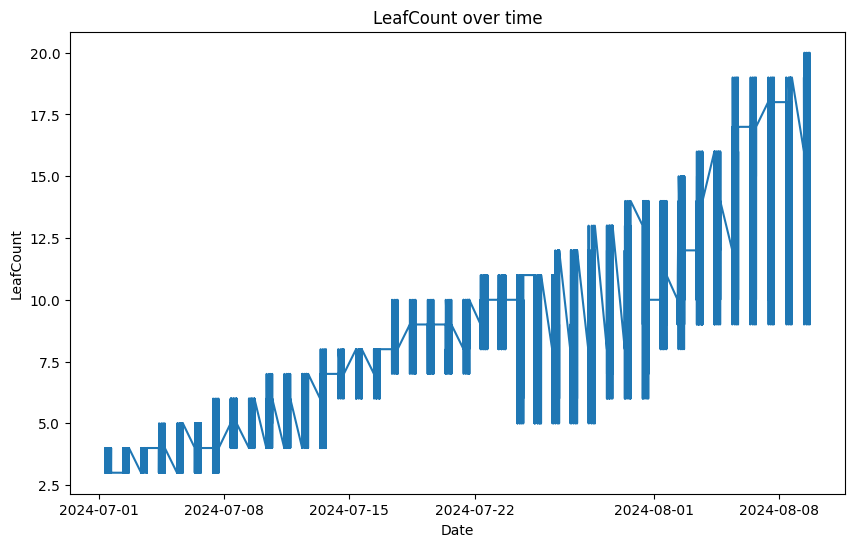

In [ ]:
# Visualize the data
plt.figure(figsize=(10, 6))
plt.plot(df_train['LeafCount'])
plt.title('LeafCount over time')
plt.xlabel('Date')
plt.ylabel('LeafCount')
plt.show()

In [ ]:
# Check stationarity
result = adfuller(df_train['LeafCount'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

ADF Statistic: -0.5174725085855295
p-value: 0.888561518088422
Critical Values:
   1%, -3.4315964280482922
Critical Values:
   5%, -2.862090792166715
Critical Values:
   10%, -2.5670631863496958


In [ ]:
# Differencing to make the series stationary
df_train['LeafCount_diff'] = df_train['LeafCount'] - df_train['LeafCount'].shift(1)
df_train.dropna(inplace=True)

result = adfuller(df_train['LeafCount_diff'])
print('ADF Statistic after differencing:', result[0])
print('p-value after differencing:', result[1])

ADF Statistic after differencing: -22.305309614491097
p-value after differencing: 0.0


In [ ]:
# Fit the ARIMA model
# Replace p, d, q with appropriate values from ACF and PACF plots
p = 1  # Typically based on PACF plot
d = 1  # Differencing order
q = 1  # Typically based on ACF plot

In [ ]:
model = ARIMA(df_train['LeafCount'], order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              LeafCount   No. Observations:                 5282
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -10246.137
Date:                Fri, 26 Jul 2024   AIC                          20498.274
Time:                        14:34:30   BIC                          20517.990
Sample:                             0   HQIC                         20505.165
                               - 5282                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1913      0.012    -16.310      0.000      -0.214      -0.168
ma.L1         -0.9682      0.003   -314.518      0.000      -0.974      -0.962
sigma2         2.8346      0.051     55.715      0.0

In [ ]:
# Check if there are any warnings or errors during fitting
if not model_fit.mle_retvals['converged']:
    print("Warning: Model fitting did not converge properly.")

## Prophet Model

In [ ]:
df_train = pd.read_csv("/content/dataset_train_final.csv")
df_test = pd.read_csv("/content/dataset_test_final.csv")

In [ ]:
# Convert datetime to datetime format
df_train['datetime'] = pd.to_datetime(df_train['datetime'])
df_test['datetime'] = pd.to_datetime(df_test['datetime'])

# Prepare training data for Prophet
df_train_prophet = df_train[['datetime', 'LeafCount', 'hole', 'temperature', 'humidity', 'light', 'pH', 'EC', 'TDS', 'WaterTemp']].copy()
df_train_prophet.rename(columns={'datetime': 'ds', 'LeafCount': 'y'}, inplace=True)

# Prepare test data for evaluation
df_test_prophet = df_test[['datetime', 'LeafCount', 'hole', 'temperature', 'humidity', 'light', 'pH', 'EC', 'TDS', 'WaterTemp']].copy()
df_test_prophet.rename(columns={'datetime': 'ds', 'LeafCount': 'y'}, inplace=True)

In [ ]:
df_train_prophet

,ds,y,hole,temperature,humidity,light,pH,EC,TDS,WaterTemp
0,2024-07-01 08:55:00,3,1,25.3,92,21910,7.0,660,330,23.1
1,2024-07-01 08:57:00,3,2,25.3,92,21910,7.0,660,330,23.1
2,2024-07-01 08:59:00,3,3,25.5,92,21060,7.8,984,492,26.1
3,2024-07-01 08:59:00,4,3,25.5,92,21060,7.0,652,326,23.1
4,2024-07-01 09:02:00,3,4,25.7,92,28330,7.0,656,328,23.1
...,...,...,...,...,...,...,...,...,...,...
5278,2024-08-09 16:44:00,18,9,25.6,44,12820,7.5,1851,930,26.3
5279,2024-08-09 16:44:00,16,9,25.6,44,12820,7.5,1851,930,23.9
5280,2024-08-09 16:45:00,15,10,25.4,44,16810,7.5,1886,943,23.9
5281,2024-08-09 16:45:00,18,10,25.4,44,16810,7.5,1886,943,23.9


In [ ]:
# Add cap for logistic growth
df_train_prophet['cap'] = 18

In [ ]:
# Initialize Prophet model with regressors
model = Prophet(growth='logistic')
model.add_regressor('hole')
model.add_regressor('temperature')
model.add_regressor('humidity')
model.add_regressor('light')
model.add_regressor('pH')
model.add_regressor('EC')
model.add_regressor('TDS')
model.add_regressor('WaterTemp')

# Fit the model
model.fit(df_train_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1qx3jqdv/lfihk6pn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1qx3jqdv/silrs__n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18991', 'data', 'file=/tmp/tmp1qx3jqdv/lfihk6pn.json', 'init=/tmp/tmp1qx3jqdv/silrs__n.json', 'output', 'file=/tmp/tmp1qx3jqdv/prophet_modelbydlcf6j/prophet_model-20240826051718.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:17:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:17:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Save the model to a file
joblib.dump(model, 'prophet_model.pkl')

['prophet_model.pkl']

# 5. Evaluation

## Arima Model

In [ ]:
# Predict on the Test Data
start = len(df_train)
end = start + len(df_test) - 1
predictions = model_fit.predict(start=start, end=end, typ='levels')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [ ]:
# Calculate Evaluation Metrics (RMSE and MAE)
rmse = np.sqrt(mean_squared_error(df_test['LeafCount'], predictions))
mae = mean_absolute_error(df_test['LeafCount'], predictions)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 8.970086115676192
MAE: 8.170746410714356


## Prophet Model

In [ ]:
# Create future DataFrame for predictions
future = model.make_future_dataframe(periods=len(df_test_prophet), freq='D')  # Match the test data period
future['cap'] = 18

In [ ]:
# Fill in the future DataFrame with the last known values of the regressors
future['hole'] = df_test_prophet['hole'].iloc[-1]
future['temperature'] = df_test_prophet['temperature'].iloc[-1]
future['humidity'] = df_test_prophet['humidity'].iloc[-1]
future['light'] = df_test_prophet['light'].iloc[-1]
future['pH'] = df_test_prophet['pH'].iloc[-1]
future['EC'] = df_test_prophet['EC'].iloc[-1]
future['TDS'] = df_test_prophet['TDS'].iloc[-1]
future['WaterTemp'] = df_test_prophet['WaterTemp'].iloc[-1]

In [ ]:
# Make predictions
forecast = model.predict(future)

# Ensure forecast includes only test dates
forecast_test = forecast[forecast['ds'].isin(df_test_prophet['ds'])]

# Merge forecast with actuals for evaluation using suffixes to avoid overlap
merged = pd.merge(
    df_test_prophet,
    forecast_test[['ds', 'yhat']],
    on='ds'
)

/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1789: RuntimeWarning: overflow encountered in exp
  sample_trends = cap / (1 + np.exp(-k_t * (t_time - m_t)))


In [ ]:
# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))
mae = mean_absolute_error(merged['y'], merged['yhat'])

# Display evaluation results
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 1.8154298562350784
MAE: 1.4857125402032283


In [ ]:
# Print the merged DataFrame to see all the columns
print("Merged DataFrame with predictions and actual values:")
print(merged)

Merged DataFrame with predictions and actual values:
                      ds   y  hole  temperature  humidity  light   pH    EC  \
0    2024-07-01 09:19:00   3     1         26.8        72  17820  7.1   918   
1    2024-07-01 09:23:00   3     2         26.6        72  16490  7.1   918   
2    2024-07-01 09:27:00   3     3         26.4        72  15160  7.1   915   
3    2024-07-01 09:28:00   3     1         26.8        72  17820  6.9   677   
4    2024-07-01 09:29:00   4    10         26.9        72  15850  6.9   677   
...                  ...  ..   ...          ...       ...    ...  ...   ...   
2649 2024-08-09 16:43:00  10     8         27.2        57  43350  7.9  1766   
2650 2024-08-09 16:44:00  16     4         25.6        44  12820  7.4  2426   
2651 2024-08-09 16:44:00  17     9         27.6        57  43940  7.9  1705   
2652 2024-08-09 16:45:00  19     5         25.4        44  16810  7.4  2426   
2653 2024-08-09 16:45:00  15    10         27.6        57  44530  7.9  1744   

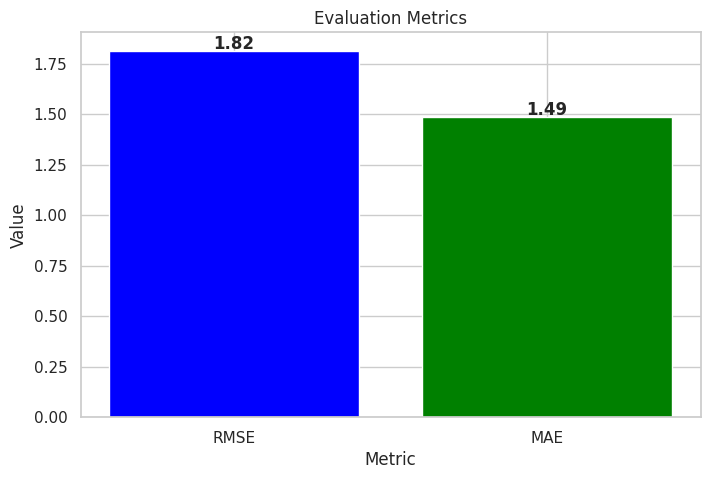

In [ ]:
# Evaluation metrics
metrics = ['RMSE', 'MAE']
values = [rmse, mae]

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'green'])

# Add title and labels
plt.title('Evaluation Metrics')
plt.xlabel('Metric')
plt.ylabel('Value')

# Display the values on the bars
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', fontweight='bold')

# Show the plot
plt.show()

# 6. Deployment

## Forecasting with ARIMA Model

In [ ]:
forecast_result = model_fit.get_forecast(steps=30)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
# Create a DataFrame to hold the results
forecast_dates = pd.date_range(start=df_train.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_df = pd.DataFrame({'Forecast': forecast.values,
                            'Lower CI': conf_int.iloc[:, 0].values,
                            'Upper CI': conf_int.iloc[:, 1].values}, index=forecast_dates)

In [ ]:
# Display the forecast table
print(forecast_df)

                      Forecast   Lower CI   Upper CI
2024-08-10 16:45:00  15.263776  11.963925  18.563627
2024-08-11 16:45:00  15.978508  12.636968  19.320049
2024-08-12 16:45:00  15.841781  12.493914  19.189649
2024-08-13 16:45:00  15.867937  12.519425  19.216449
2024-08-14 16:45:00  15.862934  12.513144  19.212723
2024-08-15 16:45:00  15.863891  12.512962  19.214820
2024-08-16 16:45:00  15.863708  12.511614  19.215801
2024-08-17 16:45:00  15.863743  12.510490  19.216995
2024-08-18 16:45:00  15.863736  12.509324  19.218148
2024-08-19 16:45:00  15.863737  12.508166  19.219309
2024-08-20 16:45:00  15.863737  12.507007  19.220467
2024-08-21 16:45:00  15.863737  12.505848  19.221626
2024-08-22 16:45:00  15.863737  12.504690  19.222784
2024-08-23 16:45:00  15.863737  12.503533  19.223941
2024-08-24 16:45:00  15.863737  12.502375  19.225099
2024-08-25 16:45:00  15.863737  12.501218  19.226255
2024-08-26 16:45:00  15.863737  12.500062  19.227412
2024-08-27 16:45:00  15.863737  12.498906  19.

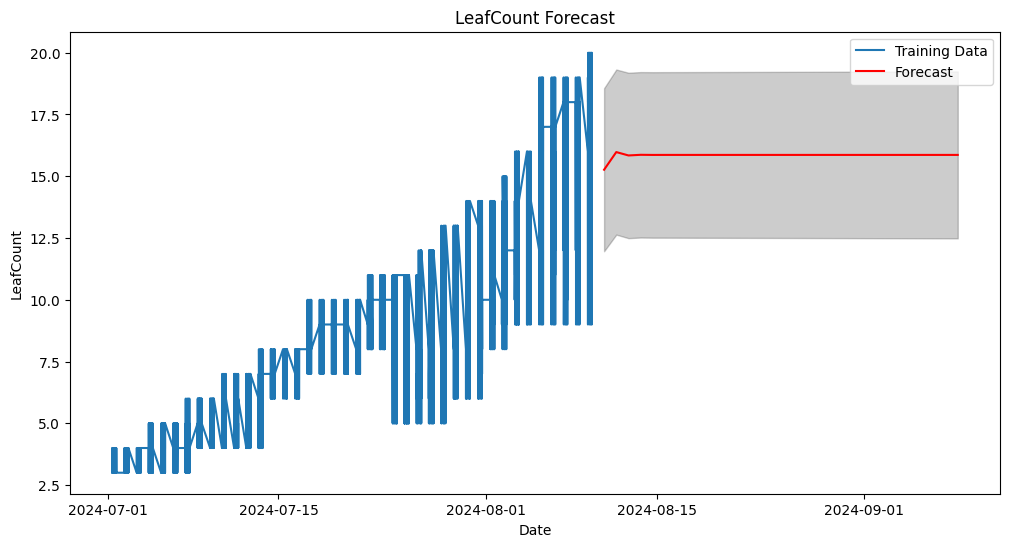

In [ ]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df_train['LeafCount'], label='Training Data')
plt.plot(forecast_df['Forecast'], label='Forecast', color='r')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], color='k', alpha=0.2)
plt.title('LeafCount Forecast')
plt.xlabel('Date')
plt.ylabel('LeafCount')
plt.legend()
plt.show()

## Forecasting with Prophet Model

In [ ]:
# Load the model from the file
model_loaded = joblib.load('prophet_model.pkl')

In [ ]:
print(model_loaded)

In [ ]:
future = model_loaded.make_future_dataframe(periods=len(df_test_prophet), freq='D')

# Assuming the cap value used in training was 18
future['cap'] = 18

In [ ]:
# Fill in the future DataFrame with the last known values of the regressors from df_test_prophet
future['hole'] = df_test_prophet['hole'].iloc[-1]
future['temperature'] = df_test_prophet['temperature'].iloc[-1]
future['humidity'] = df_test_prophet['humidity'].iloc[-1]
future['light'] = df_test_prophet['light'].iloc[-1]
future['pH'] = df_test_prophet['pH'].iloc[-1]
future['EC'] = df_test_prophet['EC'].iloc[-1]
future['TDS'] = df_test_prophet['TDS'].iloc[-1]
future['WaterTemp'] = df_test_prophet['WaterTemp'].iloc[-1]

In [ ]:
forecast = model_loaded.predict(future)

/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1789: RuntimeWarning: overflow encountered in exp
  sample_trends = cap / (1 + np.exp(-k_t * (t_time - m_t)))


In [ ]:
# Merge the forecast with the actual test data
forecast_test = forecast[forecast['ds'].isin(df_test_prophet['ds'])]
merged = pd.merge(df_test_prophet, forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

In [ ]:
print(merged)

                       ds   y  hole  temperature  humidity  light   pH    EC  \
0     2024-07-01 09:19:00   3     1         26.8        72  17820  7.1   918   
1     2024-07-01 09:23:00   3     2         26.6        72  16490  7.1   918   
2     2024-07-01 09:27:00   3     3         26.4        72  15160  7.1   915   
3     2024-07-01 09:28:00   3     1         26.8        72  17820  6.9   677   
4     2024-07-01 09:28:00   3     1         25.1        89  28330  7.8   920   
...                   ...  ..   ...          ...       ...    ...  ...   ...   
17145 2024-08-09 16:45:00  19     5         25.4        44  16810  7.3  2309   
17146 2024-08-09 16:45:00  19     5         25.4        44  16810  7.3  2309   
17147 2024-08-09 16:45:00  19     5         27.6        57  44530  7.9  2322   
17148 2024-08-09 16:45:00  19     5         27.6        57  44530  7.9  2322   
17149 2024-08-09 16:45:00  19     5         27.6        57  44530  7.9  2322   

        TDS  WaterTemp       yhat  yhat

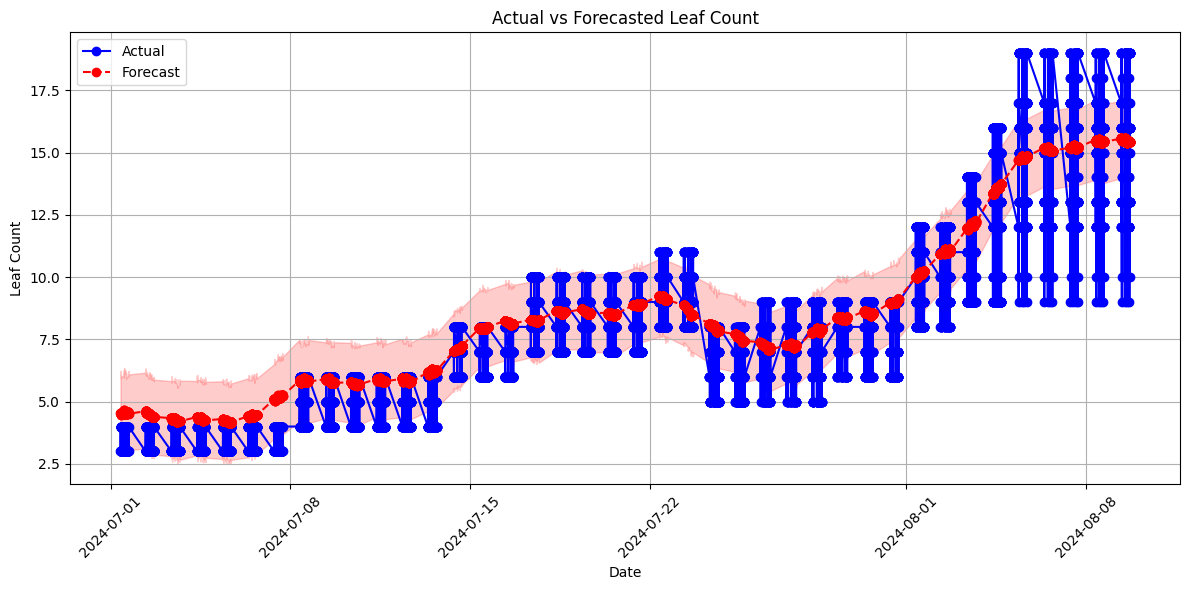

In [ ]:
# Plot the results
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(merged['ds'], merged['y'], marker='o', linestyle='-', color='blue', label='Actual')

# Plot forecasted values
plt.plot(merged['ds'], merged['yhat'], marker='o', linestyle='--', color='red', label='Forecast')

# Plot the uncertainty intervals
plt.fill_between(merged['ds'], merged['yhat_lower'], merged['yhat_upper'], color='red', alpha=0.2)

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Leaf Count')
plt.title('Actual vs Forecasted Leaf Count')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()